<a href="https://colab.research.google.com/github/marco-luzzara/boardgame-complexity-predictor/blob/master/src/predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
WORKING_LOCALLY = bool(os.getenv('WORKING_LOCALLY'))

PROCESSED_DATASET_FILE_PATH = 'data/processed_dataset.csv' if WORKING_LOCALLY \
    else '/content/drive/My Drive/Projects/IRBoardGameComplexity/processed_dataset.csv'

if not WORKING_LOCALLY:
    from google.colab import drive
    drive.mount('/content/drive')

df_features = pd.read_csv(PROCESSED_DATASET_FILE_PATH)
df_features.head()

Mounted at /content/drive


,averageweight,playingtime,rulebook_len,dice_luck_metric,drawing_luck_metric,shuffling_luck_metric,random_luck_metric,choices_amount_metric,entities_count,interaction_score,entities_variance,abstracts,cgs,childrensgames,familygames,partygames,strategygames,thematic,wargames
0,2.1579,60,677.0,0.0,0.0,1.0,0.0,6.0,5.0,20.500000,2.439704,0,0,0,1,0,0,0,0
1,3.1452,90,14753.0,0.0,2.0,4.0,4.0,218.0,62.0,47.799048,47.504669,0,0,0,0,0,1,0,0
2,1.8100,90,4167.0,0.0,0.0,0.0,0.0,44.0,39.0,26.055331,13.679672,0,0,0,0,0,0,1,0
3,1.4858,30,2899.0,0.0,12.0,4.0,0.0,24.0,14.0,27.230769,9.450702,0,0,0,1,0,0,0,0
4,2.7813,120,686.0,0.0,0.0,0.0,0.0,11.0,8.0,13.642857,1.764098,0,0,0,0,0,1,0,0


In [2]:
from collections import namedtuple
from typing import Generator, Tuple, List
from sklearn.model_selection import KFold

FeaturesWithPrediction = namedtuple('FeaturesWithPrediction', ['y', 'x'])
SplitDataset = namedtuple('SplitDataset', ['train', 'test'])

def get_actual_value(dataset: pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:, 0]

def get_features(dataset: pd.DataFrame) -> pd.DataFrame:
    return dataset.iloc[:, 1:]

def get_train_test_from_cv(kfold: KFold, dataset: pd.DataFrame) \
    -> Generator[SplitDataset, None, None]:
    '''generate K groups of train and test set from CV ((train_y, train_x), (test_y, test_x))'''
    for train_indices, test_indices in kfold.split(dataset):
        train = dataset.iloc[train_indices]
        test = dataset.iloc[test_indices]
        yield SplitDataset(\
                           FeaturesWithPrediction(get_actual_value(train), get_features(train)),
                           FeaturesWithPrediction(get_actual_value(test), get_features(test))
                           )

class Model:
    def __init__(self, instance):
        self.instance = instance
        self.name = instance.__class__.__name__

In [3]:
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from typing import List

MIN_COMPLEXITY, MAX_COMPLEXITY = 0, 5
MAX_PLOT_IN_ROW = 3
PLOT_INCHES = 6

def decorate_subplot(index: int, ax, i_model: int, title: str, y_test, predictions) -> None:
    row = i_model // MAX_PLOT_IN_ROW
    col = i_model % MAX_PLOT_IN_ROW
    subplot = ax[row][col]
    subplot.set_title(title)
    subplot.axis([MIN_COMPLEXITY, MAX_COMPLEXITY, MIN_COMPLEXITY, MAX_COMPLEXITY])
    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Actual')
    subplot.grid(True)
    subplot.plot(predictions, y_test, 'ro', [MIN_COMPLEXITY, MAX_COMPLEXITY], [MIN_COMPLEXITY, MAX_COMPLEXITY])

def create_containing_plot(plot_id: int, models: List[Model]): 
    num_models = len(models)
    containing_plot_rows = math.ceil(num_models / MAX_PLOT_IN_ROW)
    containing_plot_height = containing_plot_rows * PLOT_INCHES
    fig, ax = plt.subplots(nrows=containing_plot_rows, ncols=MAX_PLOT_IN_ROW, squeeze=False,
                           figsize=(MAX_PLOT_IN_ROW * PLOT_INCHES, containing_plot_rows * PLOT_INCHES), 
                           num=plot_id)
    for i in range(containing_plot_rows * MAX_PLOT_IN_ROW - num_models):
        fig.delaxes(ax[-1][MAX_PLOT_IN_ROW - i - 1])
    
    return fig, ax

def create_header(text: str):
    display(widgets.HTML(
        value=f"<h1>{text}</h1>"
    ))

HTML(value='<h1>Linear Models</h1>')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

HTML(value='<h1>Support Vector Machines</h1>')

HTML(value='<h1>Kernel Ridge</h1>')

HTML(value='<h1>Nearest Neighbors</h1>')

HTML(value='<h1>Gaussian Process</h1>')

HTML(value='<h1>Cross Decomposition</h1>')

/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/_pls.py:245: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/_pls.py:245: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/_pls.py:245: FutureWarning: As of version 0.24, n_components(2) should be in [1, min(n_features, n_samples, n_targets)] = [1, 1]. n_components=1 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cross_decomposition/

HTML(value='<h1>Decision Tree</h1>')

,Model,R2,MAE,MAPE,MSE
0,LinearRegression,0.627510,-0.345671,-0.161626,-0.204542
0,LassoCV,0.345582,-0.471902,-0.229824,-0.361605
0,ElasticNetCV,0.345593,-0.471911,-0.229831,-0.361599
0,RidgeCV,0.629555,-0.344018,-0.160753,-0.203446
0,BayesianRidge,0.633329,-0.340449,-0.159100,-0.201274
0,HuberRegressor,-0.033726,-0.566301,-0.252223,-0.572329
0,TweedieRegressor,0.291783,-0.483639,-0.242904,-0.392003
0,QuantileRegressor,0.260929,-0.459794,-0.212013,-0.409682
0,SVR,0.184570,-0.522739,-0.239321,-0.450636
0,KernelRidge,0.188554,-0.505119,-0.223535,-0.451264


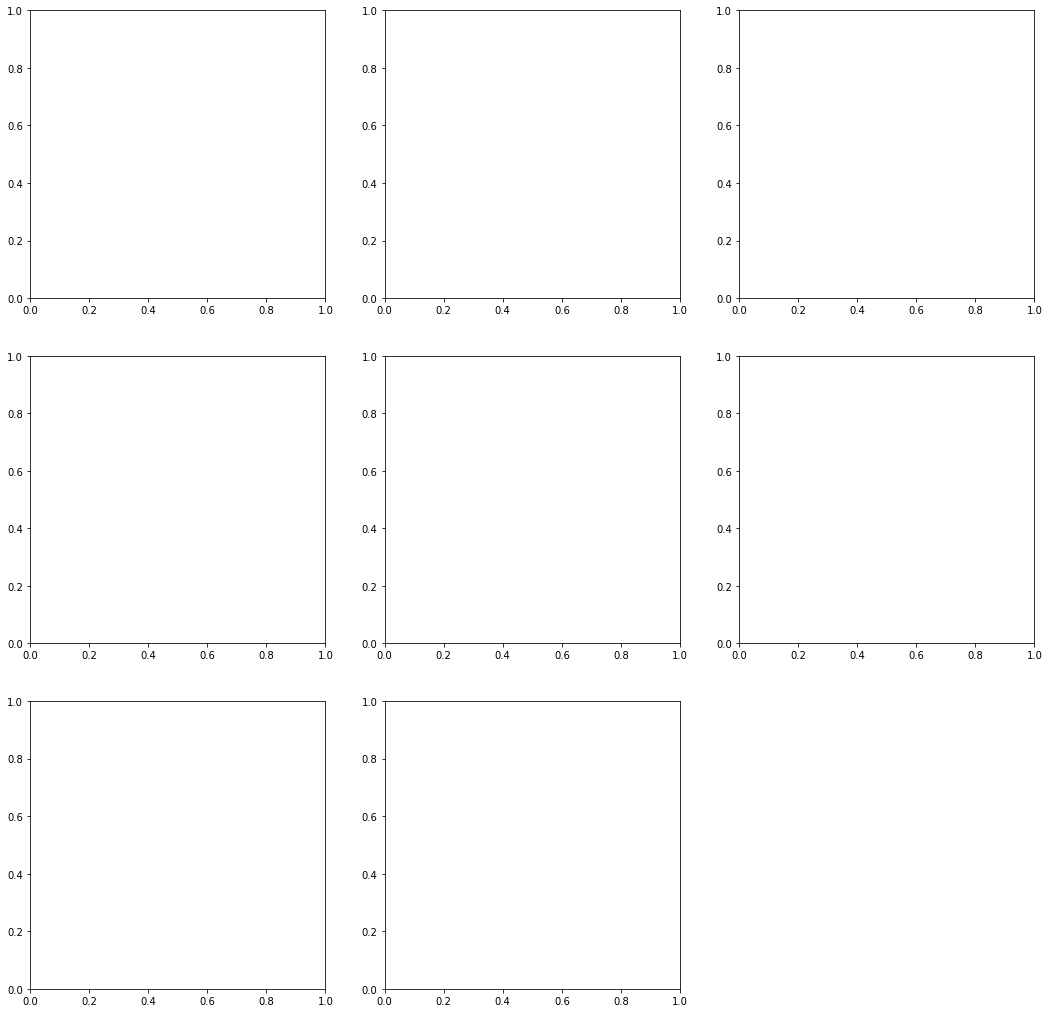

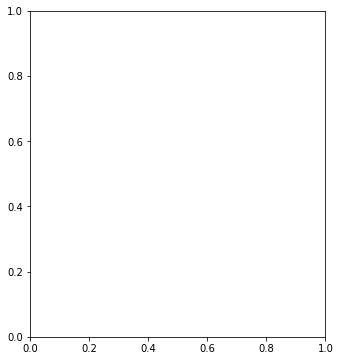

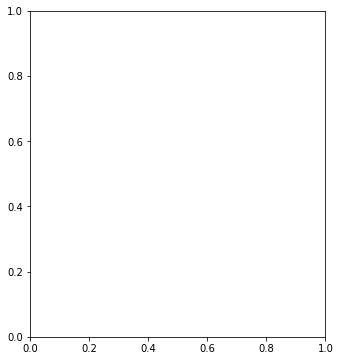

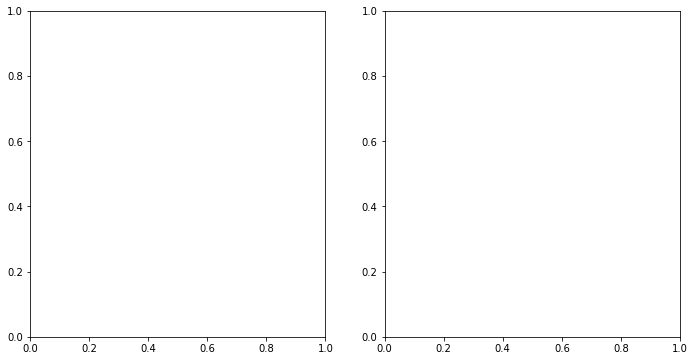

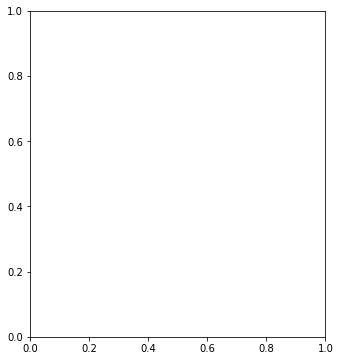

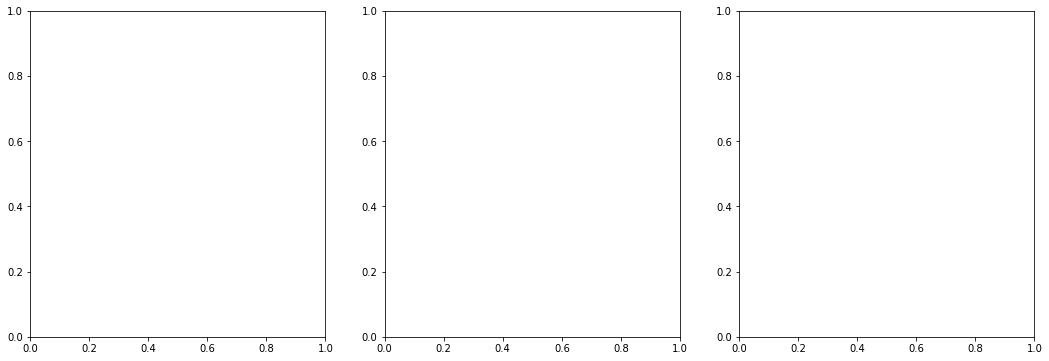

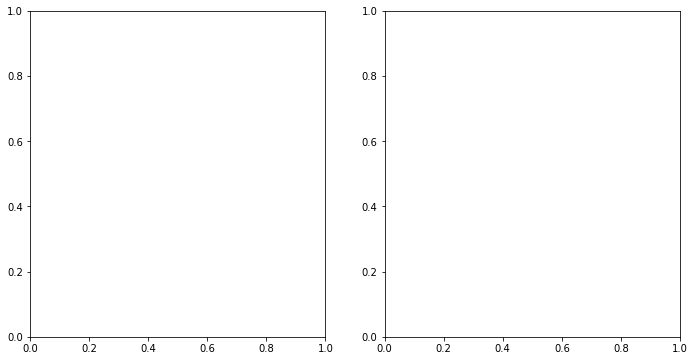

In [9]:
import numpy as np
from sklearn import linear_model, svm, kernel_ridge, neighbors, \
    gaussian_process, cross_decomposition, tree
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

models = {
    'Linear Models': [
        Model(linear_model.LinearRegression()),
        Model(linear_model.LassoCV()),
        Model(linear_model.ElasticNetCV()),
        Model(linear_model.RidgeCV()),
        Model(linear_model.BayesianRidge()),
        Model(linear_model.HuberRegressor()),
        Model(linear_model.TweedieRegressor()),
        Model(linear_model.QuantileRegressor())
    ],
    'Support Vector Machines': [Model(svm.SVR())],
    'Kernel Ridge': [Model(kernel_ridge.KernelRidge())],
    'Nearest Neighbors': [
        Model(neighbors.KNeighborsRegressor(weights='uniform')),
        Model(neighbors.KNeighborsRegressor(weights='distance'))
    ],
    'Gaussian Process': [
        Model(gaussian_process.GaussianProcessRegressor())
    ],
    'Cross Decomposition': [
        Model(cross_decomposition.PLSCanonical()),
        Model(cross_decomposition.PLSRegression()),
        Model(cross_decomposition.CCA()),
    ],
    # TODO: see ensemble methods
    'Decision Tree': [
        Model(tree.DecisionTreeRegressor()),
        Model(tree.ExtraTreeRegressor()),
    ]
}

results = pd.DataFrame(columns=['Model', 'R2', 'MAE', 'MAPE', 'MSE'])
cv_scorings = ['r2', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
splitter = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
for i_category, item in enumerate(models.items()):
    create_header(item[0])
    fig, ax = create_containing_plot(i_category, item[1])
    for i_m, model in enumerate(item[1]):
        # we can use return_estimator=True if we want to return all the fitted estimators from cross validation
        cv_results = cross_validate(model.instance, 
                                    df_features.iloc[:, 1:], 
                                    df_features.iloc[:, 0],
                                    cv = splitter,
                                    scoring = cv_scorings)
        
        r2 = np.mean(cv_results['test_r2'])
        mae = np.mean(cv_results['test_neg_mean_absolute_error'])
        mape = np.mean(cv_results['test_neg_mean_absolute_percentage_error'])
        mse = np.mean(cv_results['test_neg_mean_squared_error'])

        results = pd.concat([results, pd.DataFrame([
            { 
                'Model': model.name, 
                'R2': r2, 
                'MAE': mae, 
                'MAPE': mape,
                'MSE': mse
            }
            ])])
        #decorate_subplot(i_category, ax, i_m, model.name, best_cv_test_y, best_cv_predictions)

results